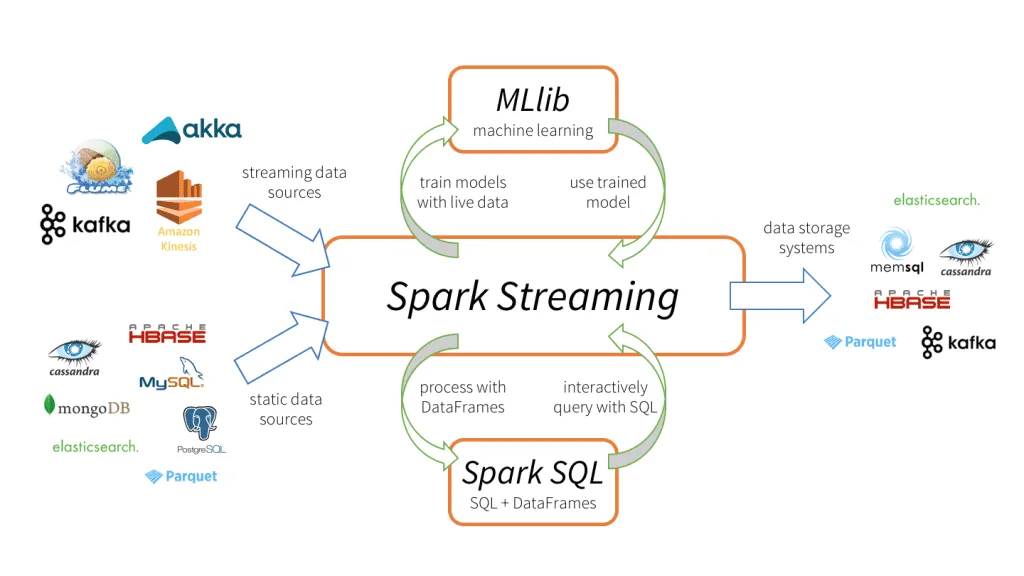

Streaming example by DecisionForest, youtube link : https://www.youtube.com/watch?v=RLfTxtgeVhM&t=531s

In [ ]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz # Download Apache Sparks.
!tar xf spark-3.5.0-bin-hadoop3.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.
!pip install pyspark==3.5.0 #--default version is 3.5.1, but to make this work we must match the spark and pyspark version. Also installs py4j.

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,118 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,383 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/mai

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("Streaming 2").getOrCreate()

In [ ]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading into a pyspark dataframe
df = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/paysim.csv", header = True, inferSchema = True)
df.show(2)
df.columns

+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|   type| amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1|PAYMENT|9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1|PAYMENT|1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
+----+-------+-------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
only showing top 2 rows



['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [ ]:
# We don't need 'isFraud' and 'isFlaggedFraud' since in a streaming system these will not be available
df.drop('isFraud', 'isFlaggedFraud')
df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud']

In [ ]:
# In this case 1 step is 1 hour of time so we can assume that the data stream feeds each hour. We can split on this.
df.groupBy('step').count().show(2)

+----+-----+
|step|count|
+----+-----+
| 148|   12|
|  31|   12|
+----+-----+
only showing top 2 rows



In [ ]:
# Creating a file per step
'''
steps = df.select('step').distinct().collect()
for step in steps[:]:
  _df = df.where(f"step = {step[0]}")
  _df.coalesce(1).write.mode('append').option("header","true").csv("/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/streaming")
'''

'\nsteps = df.select(\'step\').distinct().collect()\nfor step in steps[:]:\n  _df = df.where(f"step = {step[0]}")\n  _df.coalesce(1).write.mode(\'append\').option("header","true").csv("/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/streaming")\n'

Getting the schema and building a streams solution

In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/streaming' | head -1

part-00000-008ef7dc-0016-4552-869b-fcf09041518c-c000.csv


In [ ]:
part = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/streaming/part-00000-008ef7dc-0016-4552-869b-fcf09041518c-c000.csv",
    header = True,
    inferSchema = True
)
dataSchema = part.schema
dataSchema

StructType([StructField('step', IntegerType(), True), StructField('type', StringType(), True), StructField('amount', DoubleType(), True), StructField('nameOrig', StringType(), True), StructField('oldbalanceOrg', DoubleType(), True), StructField('newbalanceOrig', DoubleType(), True), StructField('nameDest', StringType(), True), StructField('oldbalanceDest', DoubleType(), True), StructField('newbalanceDest', DoubleType(), True), StructField('isFraud', IntegerType(), True), StructField('isFlaggedFraud', IntegerType(), True)])

In [ ]:
#maxFilesPerTrigger allows us to control how quickly spark will pick up files from the sreaming directory. We are reducing it to one per trigger of the call.

In [ ]:
stream = (
    spark.readStream.schema(dataSchema)
    .option("maxFilesPerTrigger", 1)
    .csv("/content/drive/MyDrive/Colab Notebooks/bfsi_models_practice/pyspak_streams/streaming/")
)

Working with the streaming to read and work on each part file one after another

In [ ]:
dest_count = stream.groupBy("nameDest").count().orderBy(F.desc("count"))

In [ ]:
# Writing to memory
activityQry = (
    dest_count.writeStream.queryName("dest_counts")
    .format("memory")
    .outputMode("complete")
    .start()
)

In [ ]:
# To avoid termination in production environment we should add the following line of code
# activityQry.awaitTermination()

import time

for x in range(50):
  _df = spark.sql("select * from dest_counts where nameDest != 'nameDest' and count >= 2")
  if _df.count() > 0:
    _df.show(10)

  time.sleep(0.5)

+-----------+-----+
|   nameDest|count|
+-----------+-----+
|C1470685392|    6|
| C947126193|    5|
|  C61797727|    5|
|C1152780087|    5|
| C225852166|    5|
|C2049145129|    5|
|C1104243021|    5|
|C1454189174|    5|
| C167875008|    5|
| C796568622|    5|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C680344850|    7|
|C2049145129|    7|
|C1797724563|    7|
| C240670965|    7|
|C1368674093|    7|
|C1386732390|    7|
| C947126193|    6|
|C1944598988|    6|
|C1152780087|    6|
| C581015888|    6|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C680344850|    7|
|C2049145129|    7|
|C1797724563|    7|
| C240670965|    7|
|C1368674093|    7|
|C1386732390|    7|
| C947126193|    6|
|C1944598988|    6|
|C1152780087|    6|
| C581015888|    6|
+-----------+-----+
only showing top 10 rows

+-----------+-----+
|   nameDest|count|
+-----------+-----+
| C680344850|    7|
|C

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/content/spark-3.5.0-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/content/spark-3.5.0-bin-hadoop3/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

The above will continue for all the part files unless manually interrupted. Next we will check whether the stream is active.

In [ ]:
spark.streams.active[0].isActive

True

In [ ]:
activityQry.status

{'message': 'Processing new data',
 'isDataAvailable': True,
 'isTriggerActive': True}

In [ ]:
activityQry.stop() # stopping the streaming

In [ ]:
spark.streams.active[0].isActive # the stream is not running

IndexError: list index out of range